# 2d Ising simulations using python_mc_pele

A demonstration of how to use python mc pele to run a simple 2d Ising model. The idea of python_mc_pele is to have a skeleton framework for Markov chain Monte Carlo algorithms/ (or even some non Markov chain ones like Wang Landau)

## Ising variables
The first step is to define our model. A defining aspect of the model we start with, is a set of variables over which the energy is evaluated (which we will call coordinates). For the Ising model, these happen to be discrete variables, which for an up spin would be $1$ and for a down spin would be $-1$. we can map these onto a boolean numpy array and define a function that takes us back to the Ising coordinates. The reason we usually use boolean coordinates is because they take less space when we deal with spins(although not strictly necessary)

In [1]:
%matplotlib inline 
import numpy as np
from matplotlib import pyplot as plt
# an example of variables we would have for an NxN ising model
spin_length = 10
example_coordinates = np.zeros((spin_length, spin_length), dtype=bool)
def spin_convert(bool_spin):
    """  a function to convert [True/False] to [1, -1]
    """
    return bool_spin*2-1

example_coordinates.shape[0]

10

## Ising Hamiltonian

now we want to define a hamiltonian on the boolean array variables. The Ising hamiltonian is given by 

/insert latex here/

we can define this as 


In [2]:
# slightly modified from from http://www.physics.rutgers.edu/~haule/681/src_MC/python_codes/wangLand.py
def Ising_Energy(latt):
    "Energy of a 2D periodic Ising lattice"
    Ene = 0
    Nx, Ny = latt.shape
    for i in range(Nx):
        for j in range(Ny):
            S = spin_convert(latt[i,j])
            WF = spin_convert(latt[(i+1)%Nx, j]) + spin_convert(latt[i,(j+1)%Ny]) + spin_convert(latt[(i-1)%Nx,j]) + spin_convert(latt[i,(j-1)%Ny])
            Ene += -WF*S # Each neighbor gives energy 1.0
    return int(Ene/2.)   # Each par counted twice

## The step
The step to be taken can determine how fast our algorithm converges. while we can go with something like swedsen wang or wolff, we go with a simple single flip move; a class derived from TakeStep should have the displace function that basically flips a random spin

In [3]:
from mcpele1.montecarlo.template import TakeStep
import numpy.random as random

class Ising_Flip(TakeStep):
    """ Flips a single ising spin on the lattice at random

    """
    def __init__(self, seed,  sizex, sizey):
        random.seed(seed)
        self.seeds = range(np.iinfo(np.int32).max)
        self.sizex = sizex
        self.sizey = sizey
        self.i = 0              # this is ad hoc right now, but check how the seeding should be done 

    def displace(self, coords):
        self.i=self.i+1
        random.seed(self.seeds[self.i])
        # figure out the position of the spin on the lattice
        ix = random.randint(self.sizex)
        iy = random.randint(self.sizey)
        coords[ix, iy] = not coords[ix, iy]

b = Ising_Flip(31, 10, 10)
b.displace(example_coordinates)
print(example_coordinates)

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False  True False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]


## creating the monte carlo runner
We have our physical system defined along with a step that the system can take. We also have an inbuilt metropolis test in python_mc_pele. which we can now use to create our monte carlo runner

2
[[ True False False]
 [ True False False]
 [False False  True]]
10000.0
-6.2824


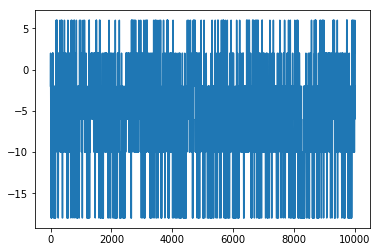

In [12]:
import sys
sys.path.append("/home/praharsh/Dropbox/research/bv-libraries/python_mc_pele")
from mcpele1.montecarlo.mc import MC
from mcpele1.accepttest import MetropolisTest
from mcpele1.action import RecordEnergyTimeSeries

class Ising_Metropolis_Monte_carlo(object):
    """ Single flip montecarlo runner for the ising model

    """
    def __init__(self, temperature, N, record_every=10, stepskip=1000, nsteps=1e5):
        random.seed(10)
        initial_coords = random.randint(2, size=(N, N), dtype =bool)  # we're starting with a random initial configuration
        # define the monte carlo runner with the potential function , initial coordinates and temperature
        self.mc = MC(Ising_Energy, initial_coords, temperature)
        print(Ising_Energy(initial_coords))
        # add the step type
        self.take_step = Ising_Flip(10, N, N)
        seeds = range(np.iinfo(np.int32).max)
        # accept test
        self.accept_test = MetropolisTest(seeds)

        # action
        
        # record_energy
        self.action = RecordEnergyTimeSeries(record_every, stepskip)
        
        print(initial_coords)
        self.mc.set_take_step(self.take_step)
        self.mc.add_accept_test(self.accept_test)
        self.mc.add_action(self.action)
        self.nsteps = nsteps
    def run(self):
        print(self.nsteps)
        self.mc.run(self.nsteps)

    def get_et_series(self):
        return np.array(self.action.get_energy_time_series())

# Ising metropolis methods for the Ising model 
ising_mc = Ising_Metropolis_Monte_carlo(4, 3, record_every=1, stepskip=0, nsteps=1e4)

ising_mc.run()



## generating the energy time series for a few temperatures

In [20]:
temps = [ 0.1, 0.5, 1, 2, 4, 6, 8, 10, 20, 30, 40]
etavl = []
for temp in temps:
    ising_mc = Ising_Metropolis_Monte_carlo(temp, 4, record_every=1, stepskip=0, nsteps=1e4)
    ising_mc.run()
    etavl.append(np.average(ising_mc.get_et_series())/4)
    



0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False False]
 [ True False  True False]
 [False False  True False]]
10000.0
0
[[ True False False  True]
 [False False False

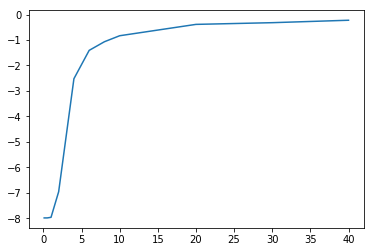

In [22]:
plt.plot(temps, etavl)
plt.show()